<a href="https://colab.research.google.com/github/HanaDelport/Projet-NLP/blob/main/Classification_commentaires_toxiques_V0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importation des packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import tensorflow as tf

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D, Flatten, TextVectorization
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers

# Importation des données

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1mx-CAzT10YKrmxHfYDP_1Oef7PVGUr7s?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Etude du jeu de données

In [ ]:
# Création d'une classe clean_comment
data['clean_comments'] = 1 - data[data.columns[2:]].max(axis=1)

In [ ]:
# Séparation des différentes classes de toxicité

list_classes = ["clean_comments", "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = data[list_classes].values
list_sentences_train = data["comment_text"]

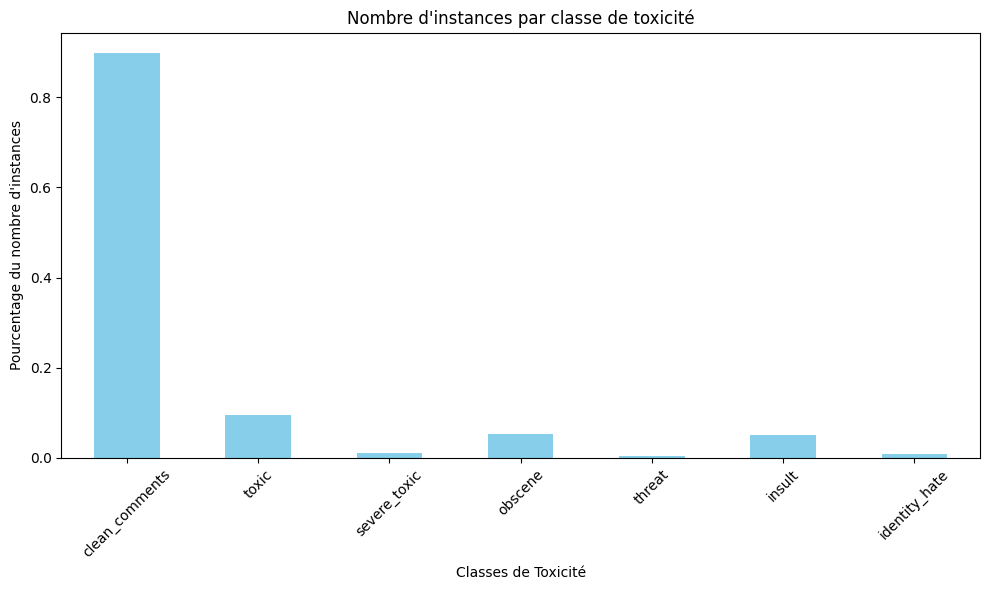

In [ ]:
# Compter le nombre d'instances pour chaque classe de toxicité
class_counts = data[list_classes].sum()
percent_class_counts = class_counts / len(data)

# Créer le barplot
plt.figure(figsize=(10, 6))
percent_class_counts.plot(kind='bar', color='skyblue')
plt.title('Nombre d\'instances par classe de toxicité')
plt.xlabel('Classes de Toxicité')
plt.ylabel('Pourcentage du nombre d\'instances')
plt.xticks(rotation=45)  # Rotation des labels sur l'axe x pour une meilleure lisibilité
plt.tight_layout()  # Ajustement automatique de la disposition
plt.show()

In [ ]:
print(class_counts)

clean_comments    143346
toxic              15294
severe_toxic        1595
obscene             8449
threat               478
insult              7877
identity_hate       1405
dtype: int64


In [ ]:
print(percent_class_counts)

clean_comments    0.898321
toxic             0.095844
severe_toxic      0.009996
obscene           0.052948
threat            0.002996
insult            0.049364
identity_hate     0.008805
dtype: float64


# Préparation des données

In [ ]:
X = list_sentences_train
y = data[data.columns[2:8]].values

In [ ]:
max_len = 20000 # nombre de mots dans le vocab

vectorizer = TextVectorization(max_tokens = max_len, output_sequence_length = 1800, output_mode = 'int')
vectorizer.adapt(X.values)
tokenized_text = vectorizer(X.values)

In [ ]:
tokenized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[ 645,   76,    2, ...,    0,    0,    0],
       [   1,   54, 2489, ...,    0,    0,    0],
       [ 425,  441,   70, ...,    0,    0,    0],
       ...,
       [   1, 7392,  383, ...,    0,    0,    0],
       [   5,   12,  534, ...,    0,    0,    0],
       [   5,    8,  130, ...,    0,    0,    0]])>

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((tokenized_text,y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [ ]:
batch_X, batch_y = dataset.as_numpy_iterator().next()

In [ ]:
train = dataset.take(int(len(dataset)*.6))
val = dataset.skip(int(len(dataset)*.6)).take(int(len(dataset)*.3))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [ ]:
train_generator = train.as_numpy_iterator()

# Entraînement du modèle baseline

In [ ]:
model = Sequential()
model.add(Embedding(max_len+1, 32))
model.add(Bidirectional(LSTM(32, activation = 'tanh')))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(6, activation = 'sigmoid'))

In [ ]:
model.compile(loss = 'BinaryCrossentropy', optimizer = 'Adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          640032    
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [ ]:
history = model.fit(train, epochs = 2, validation_data = val)

Epoch 1/2
5984/5984 [==============================] - 9454s 2s/step - loss: 0.0671 - val_loss: 0.0509
Epoch 2/2
5984/5984 [==============================] - 9382s 2s/step - loss: 0.0513 - val_loss: 0.0468


In [ ]:
history.history

{'loss': [0.06709451973438263, 0.05134080722928047],
 'val_loss': [0.05094882473349571, 0.04678122699260712]}

<Figure size 800x500 with 0 Axes>

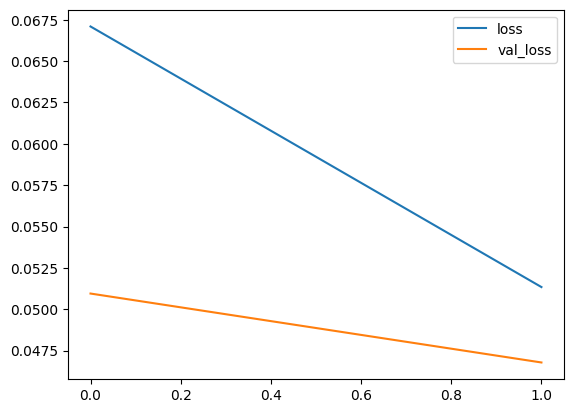

In [ ]:
plt.figure(figsize = (8,5))
pd.DataFrame(history.history).plot()
plt.show()

# Itération de la modélisation

In [ ]:
input_text = vectorizer('You freaking suck! I am gonna hurt you')

In [ ]:
batch = test.as_numpy_iterator().next()

In [ ]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [ ]:
model.predict(batch_X).astype(int)

1/1 [==============================] - 1s 524ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
batch_y

array([[0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
  X_true, y_true = batch
  yhat = model.predict(X_true)

  y_true = y_true.flatten()
  yhat = yhat.flatten()

  pre.update_state(y_true, yhat)
  re.update_state(y_true, yhat)
  acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 180ms/step


In [ ]:
print(f'Precision : {pre.result().numpy()}, Recall : {re.result().numpy()}, Accuracy : {acc.result().numpy()}')

Precision : 0.803193211555481, Recall : 0.7083333134651184, Accuracy : 0.4754262864589691
